# Bitcoin Recurrent Neural Network
- Recent 1000
- Long short-term memory(LSTM)


## 1. Settings
### 1) Import required libraries

In [52]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from visdom import Visdom
viz = Visdom()

In [53]:
import string
import random
import re
import time, math
from utils2 import *
import matplotlib.pyplot as plt

## 2) Hyperparameter

In [54]:
num_epochs = 5000
hidden_size = 30
output_size=1
batch_size =1
num_layers = 3
lr = 0.002
NUM_STEPS = 500
chunk_len=200
num_layers = 1
recent_num =1000
path = '../data/bitstamp.csv'

In [55]:
# train Parameters
seq_length = 200
sub_seq_length = 150
data_dim = 18
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 101
plot_name = 'LSTM_new_01'

## 2. Data

### 2) Get data

In [56]:
data_raw = data_loading(path)

In [57]:
data_raw[-1]

array([  2.35227598e+04,   2.42228105e+04,   9.98175250e+05,
         1.38100004e+01,   5.27782900e+06,   8.50000024e-01,
         6.78738750e+06,   2.36772000e+05,   2.27242000e+05,
         4.77000008e+01,   3.28761011e+03,   1.28863000e+03,
         1.13500004e+01,   7.38174023e+03,   6.66230011e+00,
         1.09690804e+02,   9.67999995e-01,   8.26722336e+00], dtype=float32)

In [58]:
data = data_raw[-recent_num:,:]

In [59]:
data.shape

(1000, 18)

### 3) Chunk into input & label

In [60]:
def random_chunk():
    start_index = random.randint(0, len(data) - chunk_len)
    end_index = start_index + chunk_len + 1
    return data[start_index:end_index]

print(random_chunk().shape)

(201, 18)


In [61]:
def random_training_set():    
    chunk = random_chunk()
    inp = torch.from_numpy(chunk[:-1])
    target = torch.from_numpy(chunk[1:,-1])
    return Variable(inp).cuda(), Variable(target).cuda()

## 3. Model & Optimizer
### 1) Model

In [62]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=num_layers):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.encoder = nn.Linear(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size,hidden_size,num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    def forward(self, input, hidden):
        out = self.encoder(input.view(1,-1))
        #out = self.encoder(input)
        out,hidden, = self.rnn(out.view(1,1,-1),hidden)
        out = self.decoder(out.view(batch_size,-1))
        return out,hidden
    def init_hidden(self):
        hidden = Variable(torch.zeros(num_layers,batch_size,hidden_size)).cuda()
        return hidden
model = RNN(data.shape[1], hidden_size, output_size, num_layers).cuda()

### 2) Loss & Optimizer

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss()

### 3) Training

In [64]:
for i in range(num_epochs):
    inp , label = random_training_set()
    hidden = model.init_hidden()
    loss = 0
    optimizer.zero_grad()
    for j in range(chunk_len-1):
        x  = inp[j]
        y_ = label[j]
        y,hidden = model(x,hidden)
        loss += loss_func(y,y_)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(i)
        print("\n",loss/chunk_len,"\n")

0

 Variable containing:
 29.2102
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

100

 Variable containing:
 3.7032
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

200

 Variable containing:
 1.5315
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

300

 Variable containing:
 1.0548
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

400

 Variable containing:
 0.5180
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

500

 Variable containing:
 0.2815
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

600

 Variable containing:
1.00000e-02 *
  7.3241
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

700

 Variable containing:
 1.1112
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

800

 Variable containing:
 0.3303
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

900

 Variable containing:
1.00000e-02 *
  6.2064
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

1000

 Variable containing:
1.00000e-02 *
  8.6508
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

1100

 Variable containing:
 0.4020
[torch.cuda.FloatTensor of s

### 4. Inference

In [17]:
def inference_set():    
    inp = torch.from_numpy(data[:-1])
    target = torch.from_numpy(data[1:,-1])
    return Variable(inp).cuda(), Variable(target).cuda()

In [18]:
aa = data[:-1]
aa.shape

(999, 18)

In [50]:
def inference():
    inp , label = inference_set()
    hidden = model.init_hidden()
    optimizer.zero_grad()
    real=[]
    predict=[]
    for j in range(len(inp)-1):
        x  = inp[j]
        y_ = label[j]
        y,hidden = model(x,hidden)
        #print(y_.cpu().data.numpy()[0])
        real.append(y_.cpu().data.numpy()[0])
        #print(y.cpu().data.numpy()[0][0])
        predict.append(y.cpu().data.numpy()[0][0])
        #predict.np.append(y.cpu())
        if j>800:
            print(x)
            print(y_)
            print(y)
            print(hidden)
    return real , predict

In [51]:
real, predict = inference()

Variable containing:
 4.3482e+03
 1.2080e+04
 9.5794e+05
 2.1340e+01
 3.0430e+06
 9.1000e-01
 1.9350e+06
 2.8633e+05
 2.8134e+05
 5.3830e+01
 3.1601e+03
 1.2185e+03
 1.0970e+01
 7.1883e+03
 6.8698e+00
 1.1265e+02
 9.9240e-01
 6.9236e+00
[torch.cuda.FloatTensor of size 18 (GPU 0)]

Variable containing:
 6.9288
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 6.5759
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
( 0 ,.,.) = 

Columns 0 to 18 
    1  -1   1   1   1  -1  -1   1  -1  -1   1   1  -1   1   1   1  -1   1   1

Columns 19 to 37 
    1   1   1   1  -1   1   1   1  -1  -1   1   1   1  -1  -1   1  -1  -1   1

Columns 38 to 56 
    1   1  -1   1  -1   1  -1   1  -1   1   1  -1  -1   1   1   1  -1   1   1

Columns 57 to 75 
    1   1  -1   1  -1   1   1  -1  -1  -1  -1  -1   1   1   1  -1  -1  -1   1

Columns 76 to 94 
    1   1  -1   1   1  -1   1  -1  -1   1   1  -1  -1  -1   1  -1  -1   1   1

Columns 95 to 99 
    1   1  -1  -1  -1
[torch.cuda

Variable containing:
 8.6871e+03
 6.4288e+03
 9.0095e+05
 7.2000e+00
 3.9255e+06
 9.3000e-01
 2.0466e+06
 2.2192e+05
 2.1780e+05
 4.7730e+01
 3.2689e+03
 1.2588e+03
 1.2500e+01
 7.2935e+03
 6.8728e+00
 1.1062e+02
 9.8550e-01
 6.9154e+00
[torch.cuda.FloatTensor of size 18 (GPU 0)]

Variable containing:
 6.9531
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 6.5759
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
( 0 ,.,.) = 

Columns 0 to 18 
    1  -1   1   1   1  -1  -1   1  -1  -1   1   1  -1   1   1   1  -1   1   1

Columns 19 to 37 
    1   1   1   1  -1   1   1   1  -1  -1   1   1   1  -1  -1   1  -1  -1   1

Columns 38 to 56 
    1   1  -1   1  -1   1  -1   1  -1   1   1  -1  -1   1   1   1  -1   1   1

Columns 57 to 75 
    1   1  -1   1  -1   1   1  -1  -1  -1  -1  -1   1   1   1  -1  -1  -1   1

Columns 76 to 94 
    1   1  -1   1   1  -1   1  -1  -1   1   1  -1  -1  -1   1  -1  -1   1   1

Columns 95 to 99 
    1   1  -1  -1  -1
[torch.cuda


Variable containing:
 1.7797e+04
 1.2027e+04
 9.8188e+05
 1.3690e+01
 3.6744e+06
 5.9000e-01
 3.3563e+06
 2.3398e+05
 2.2856e+05
 4.9070e+01
 3.1078e+03
 1.2587e+03
 1.5590e+01
 7.5035e+03
 6.8819e+00
 1.1095e+02
 9.7870e-01
 7.4818e+00
[torch.cuda.FloatTensor of size 18 (GPU 0)]

Variable containing:
 7.5102
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 6.5759
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
( 0 ,.,.) = 

Columns 0 to 18 
    1  -1   1   1   1  -1  -1   1  -1  -1   1   1  -1   1   1   1  -1   1   1

Columns 19 to 37 
    1   1   1   1  -1   1   1   1  -1  -1   1   1   1  -1  -1   1  -1  -1   1

Columns 38 to 56 
    1   1  -1   1  -1   1  -1   1  -1   1   1  -1  -1   1   1   1  -1   1   1

Columns 57 to 75 
    1   1  -1   1  -1   1   1  -1  -1  -1  -1  -1   1   1   1  -1  -1  -1   1

Columns 76 to 94 
    1   1  -1   1   1  -1   1  -1  -1   1   1  -1  -1  -1   1  -1  -1   1   1

Columns 95 to 99 
    1   1  -1  -1  -1
[torch.cud

Variable containing:
( 0 ,.,.) = 

Columns 0 to 18 
    1  -1   1   1   1  -1  -1   1  -1  -1   1   1  -1   1   1   1  -1   1   1

Columns 19 to 37 
    1   1   1   1  -1   1   1   1  -1  -1   1   1   1  -1  -1   1  -1  -1   1

Columns 38 to 56 
    1   1  -1   1  -1   1  -1   1  -1   1   1  -1  -1   1   1   1  -1   1   1

Columns 57 to 75 
    1   1  -1   1  -1   1   1  -1  -1  -1  -1  -1   1   1   1  -1  -1  -1   1

Columns 76 to 94 
    1   1  -1   1   1  -1   1  -1  -1   1   1  -1  -1  -1   1  -1  -1   1   1

Columns 95 to 99 
    1   1  -1  -1  -1
[torch.cuda.FloatTensor of size 1x1x100 (GPU 0)]

Variable containing:
 9.4306e+03
 8.3151e+03
 9.3706e+05
 1.4770e+01
 5.0023e+06
 9.7000e-01
 5.0920e+06
 2.2511e+05
 2.1898e+05
 4.4230e+01
 3.2038e+03
 1.2097e+03
 1.1190e+01
 7.3509e+03
 6.8058e+00
 1.1391e+02
 9.6390e-01
 7.8364e+00
[torch.cuda.FloatTensor of size 18 (GPU 0)]

Variable containing:
 7.8292
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 6.5759
[torch.

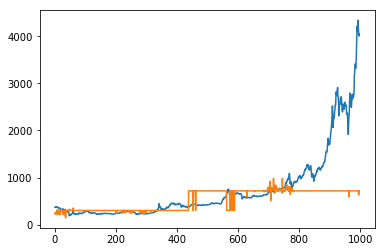

In [49]:
plt.figure
plt.plot(np.exp(real))
plt.plot(np.exp(predict))
plt.show()

In [22]:
real[800:810]

[6.9235892,
 6.9287629,
 6.9503355,
 6.9523749,
 6.9043593,
 6.8851619,
 6.9159122,
 6.9100924,
 6.9022098,
 6.9143934]

In [23]:
predict[800:810]

[6.1818452,
 6.1818452,
 6.1818452,
 6.1818452,
 6.1818452,
 6.1818452,
 6.1818452,
 6.1818452,
 6.1818452,
 6.1818452]

In [21]:
MAPE = np.sum([np.abs((np.exp(real)-np.exp(predict)))/np.exp(predict)])/len(real)

In [22]:
MAPE

0.6619677954541896